<a href="https://colab.research.google.com/github/cidels/Predicting-the-Life-Level-of-HCC-Patients-Using-the-Random-Forest-Algorithm/blob/main/skripsi_survival_prediction_with_logistic_regression_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Survival prediction with Logistic Regression

#### AUTHOR
Maciej Januszewski  
Last update: May 11th, 2018

### ABOUT HCC DATASET

**HCC** dataset was obtained at a University Hospital in Portugal and contais several demographic, risk factors, laboratory and overall survival features of 165 real patients diagnosed with HCC. 

The dataset contains 49 features selected according to the EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines, which are the current state-of-the-art on the management of HCC.

This is an heterogeneous dataset, with 23 quantitative variables, and 26 qualitative variables. Overall, missing data represents 10.22% of the whole dataset and only eight patients have complete information in all fields (4.85%). 

The target variables is the survival at 1 year, and was encoded as a binary variable: 0 (die) and 1 (lives). A certain degree of class-imbalance is also present (63 cases labeled as “dies” and 102 as “lives”).

In [1]:
import operator
from fancyimpute import KNN 
from sklearn.preprocessing import LabelBinarizer
import math
from operator import itemgetter 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, classification_report, r2_score, make_scorer, roc_curve, auc
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

%matplotlib inline

plt.style.use('bmh')

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EDA

Dataset doesn't contain column names. To understand better data, I put columns.

In [ ]:
columns = [
    # nominal
    'gender', #0-1
    'symptoms', #0-1
    'alcohol', #0-1
    'hepatitis b surface antigen', #0-1
    'hepatitis b e antigen', #0-1
    'hepatitis b core antibody', #0-1
    'hepatitis c virus antibody', #0-1
    'cirrhosis', #0-1
    'endemic countries', #0-1
    'smoking', #0-1
    'diabetes', #0-1
    'obesity', #0-1
    'hemochromatosis', #0-1
    'arterial hypertension', #0-1
    'chronic renal insufficiency', #0-1
    'human immunodeficiency virus', #0-1
    'nonalcoholic steatohepatitis', #0-1
    'esophageal varices', #0-1
    'splenomegaly', #0-1
    'portal hypertension', #0-1
    'portal vein thrombosis', #0-1
    'liver metastasis', #0-1
    'radiological hallmark', #0-1
    
    # integer
    'age', # age at diagnosis
    
    # continuous
    'grams of alcohol per day',
    'packs of cigarets per year',
    
    # ordinal
    'performance status',
    'encephalopathy degree',
    'ascites degree',
     
    # continuous   
    'international normalised ratio',
    'alpha-fetoprotein',
    'haemoglobin',
    'mean corpuscular volume',
    'leukocytes',
    'platelets',
    'albumin',
    'total bilirubin',
    'alanine transaminase',
    'aspartate transaminase',
    'gamma glutamyl transferase',
    'alkaline phosphatase',
    'total proteins',
    'creatinine',
    
    # integer
    'number of nodules',
    
    # continuous
    'major dimension of nodule cm',
    'direct bilirubin mg/dL',
    'iron',
    'oxygen saturation %',
    'ferritin',
        
    #nominal
    'class attribute', #0-1
]

columns = list([x.replace(' ', '_').strip() for x in columns])

In [ ]:
df = pd.read_csv(
    'drive/My Drive/hcc-data.csv', 
    names=columns, 
    header=None, 
    na_values=['?']
)

In [ ]:
data = df.copy()

### EDA

In [ ]:
data.head()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67,137.0,15.0,0,1.0,1.0,1.53,95.0,13.7,106.6,4.9,99.0,3.4,2.1,34.0,41.0,183.0,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,62,0.0,NaN,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,78,50.0,50.0,2,1.0,2.0,0.96,5.8,8.9,79.8,8.4,472.0,3.3,0.4,58.0,68.0,202.0,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.0,30.0,0,1.0,1.0,0.95,2440.0,13.4,97.1,9.0,279.0,3.7,0.4,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,76,100.0,30.0,0,1.0,1.0,0.94,49.0,14.3,95.1,6.4,199.0,4.1,0.7,147.0,306.0,173.0,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          165 non-null    int64  
 1   symptoms                        147 non-null    float64
 2   alcohol                         165 non-null    int64  
 3   hepatitis_b_surface_antigen     148 non-null    float64
 4   hepatitis_b_e_antigen           126 non-null    float64
 5   hepatitis_b_core_antibody       141 non-null    float64
 6   hepatitis_c_virus_antibody      156 non-null    float64
 7   cirrhosis                       165 non-null    int64  
 8   endemic_countries               126 non-null    float64
 9   smoking                         124 non-null    float64
 10  diabetes                        162 non-null    float64
 11  obesity                         155 non-null    float64
 12  hemochromatosis                 142 

In [ ]:
data.isnull().sum(axis=0)

gender                             0
symptoms                          18
alcohol                            0
hepatitis_b_surface_antigen       17
hepatitis_b_e_antigen             39
hepatitis_b_core_antibody         24
hepatitis_c_virus_antibody         9
cirrhosis                          0
endemic_countries                 39
smoking                           41
diabetes                           3
obesity                           10
hemochromatosis                   23
arterial_hypertension              3
chronic_renal_insufficiency        2
human_immunodeficiency_virus      14
nonalcoholic_steatohepatitis      22
esophageal_varices                52
splenomegaly                      15
portal_hypertension               11
portal_vein_thrombosis             3
liver_metastasis                   4
radiological_hallmark              2
age                                0
grams_of_alcohol_per_day          48
packs_of_cigarets_per_year        53
performance_status                 0
e

In [ ]:
data.describe()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute
count,165.000000,147.000000,165.000000,148.000000,126.000000,141.000000,156.000000,165.000000,126.000000,124.000000,162.000000,155.000000,142.000000,162.000000,163.000000,151.000000,143.000000,113.000000,150.00000,154.000000,162.000000,161.000000,163.000000,165.000000,117.000000,112.000000,165.000000,164.000000,163.000000,161.000000,1.570000e+02,162.000000,162.000000,162.000000,162.000000,159.000000,160.000000,161.000000,162.000000,162.000000,162.000000,154.000000,158.000000,163.000000,145.000000,121.000000,86.000000,85.000000,85.000000,165.000000
mean,0.806061,0.639456,0.739394,0.108108,0.007937,0.269504,0.217949,0.903030,0.079365,0.508065,0.345679,0.129032,0.049296,0.364198,0.122699,0.019868,0.055944,0.610619,0.56000,0.714286,0.222222,0.223602,0.680982,64.690909,71.008547,20.464286,1.018182,1.158537,1.441718,1.421851,1.929995e+04,12.879012,95.119753,1473.961549,113206.442654,3.445535,3.087938,67.093168,96.382716,268.026543,212.211605,8.961039,1.127089,2.736196,6.851172,1.930000,85.598837,37.028941,438.997647,0.618182
std,0.396586,0.481800,0.440302,0.311571,0.089087,0.445284,0.414182,0.296817,0.271387,0.501963,0.477064,0.336322,0.217251,0.482697,0.329103,0.140009,0.230621,0.489782,0.49805,0.453228,0.417029,0.417959,0.467533,13.319534,76.277680,51.565130,1.181528,0.428137,0.685819,0.477816,1.490983e+05,2.145237,8.405846,2909.106006,107118.632481,0.685132,5.499379,57.539747,87.484241,258.750319,167.943548,11.728739,0.955856,1.797901,5.095042,4.210452,55.698995,28.993552,457.114454,0.487311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.840000,1.200000e+00,5.000000,69.500000,2.200000,1.710000,1.900000,0.300000,11.000000,17.000000,23.000000,1.280000,3.900000,0.200000,0.000000,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.170000,5.200000e+00,11.425000,89.775000,5.100000,255.750000,3.000000,0.800000,31.000000,46.250000,91.250000,108.250000,6.300000,0.700000,1.000000,3.000000,0.370000,40.500000,16.000000,84.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,66.000000,75.000000,0.000000,1.000000,1.000000,1.000000,1.300000,3.300000e+01,13.050000,94.950000,7.200000,93000.000000,3.400000,1.400000,50.000000,71.000000,179.500000,162.000000,7.050000,0.850000,2.000000,5.000000,0.700000,83.000000,27.000000,295.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.0000

#### What do we know about patients ?

In [ ]:
data['age'].isnull().sum()

0

In [ ]:
print('The oldest patient: {} years.'.format(data['age'].max()))
print('The youngest patient: {} years.'.format(data['age'].min()))
print('Average age: {} years.'.format(data['age'].mean()))
print('Median age: {} years.'.format(data['age'].median(skipna=True)))

The oldest patient: 93 years.
The youngest patient: 20 years.
Average age: 64.69090909090909 years.
Median age: 66.0 years.


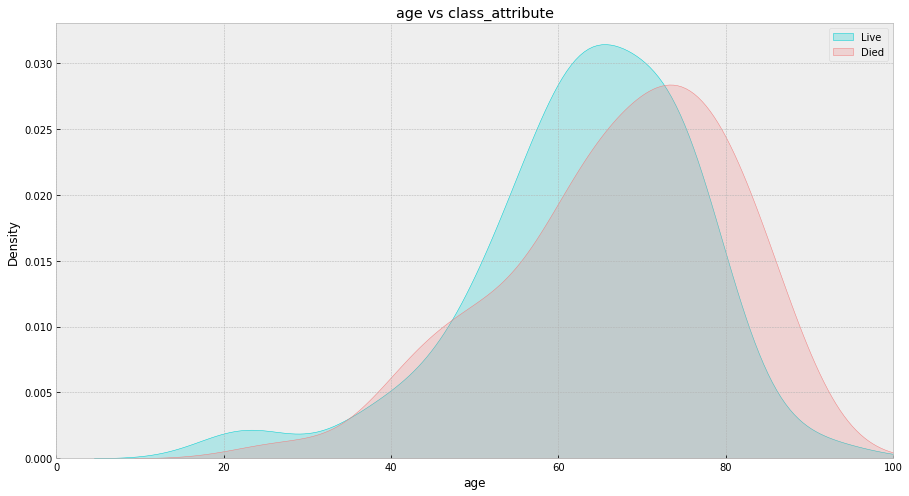

In [ ]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.age[data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.age[data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('age vs class_attribute')
plt.xlim(0,100)
plt.show()

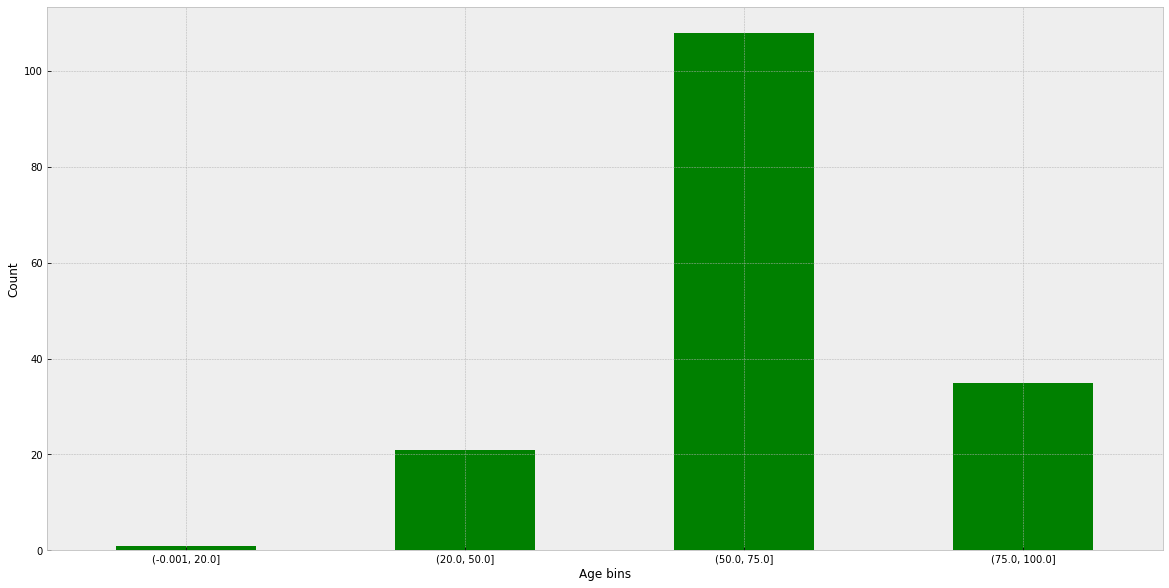

In [ ]:
bins = [0, 20, 50, 75, 100]

out = pd.cut(
    data.age, 
    bins=bins,
    include_lowest=True
)

ax = out.value_counts(sort=False).plot.bar(
    rot=0, 
    color="g", 
    figsize=(20,10)
)

plt.xlabel('Age bins')
plt.ylabel('Count')
plt.show()

The age distribution for survivors and deceased is quite similar. After binning and plots analysis we can see that the largest proportion of survivors/died patients were in age range of 50-75.

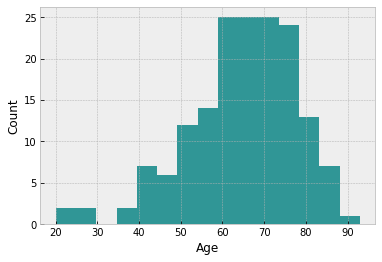

In [ ]:
ax = data.age.hist(
    bins=15,
    color='teal', 
    alpha=0.8
)

ax.set(
    xlabel='Age', 
    ylabel='Count'
)

plt.show()

### GRAMS_OF_ALCOHOL_PER_DAY VS CLASS_ATTRIBUTE (SURVIVAL)

In [ ]:
data['grams_of_alcohol_per_day'].isnull().sum()

48

In [ ]:
max(data["grams_of_alcohol_per_day"])

500.0

In [ ]:
min(data["grams_of_alcohol_per_day"])

0.0

In [ ]:
data["grams_of_alcohol_per_day"].mean()

71.00854700854701

In [ ]:
data["grams_of_alcohol_per_day"].median()

75.0

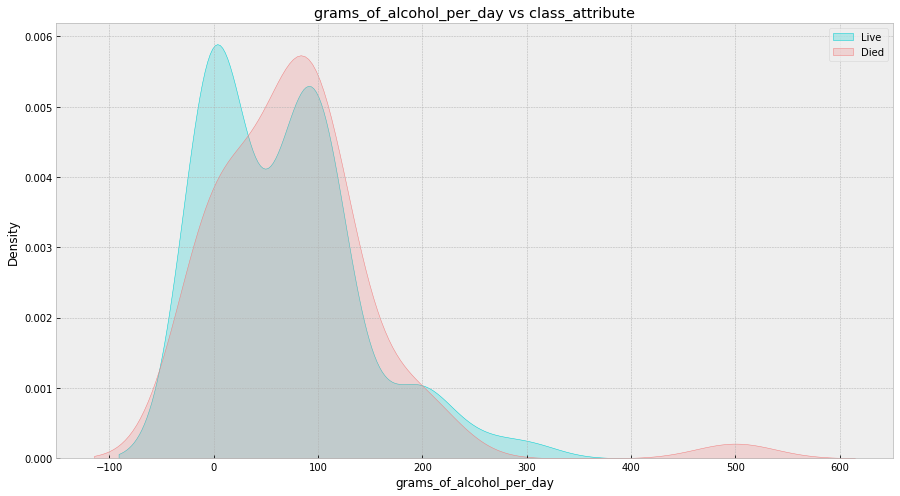

In [ ]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.grams_of_alcohol_per_day[data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.grams_of_alcohol_per_day[data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('grams_of_alcohol_per_day vs class_attribute')
plt.show()

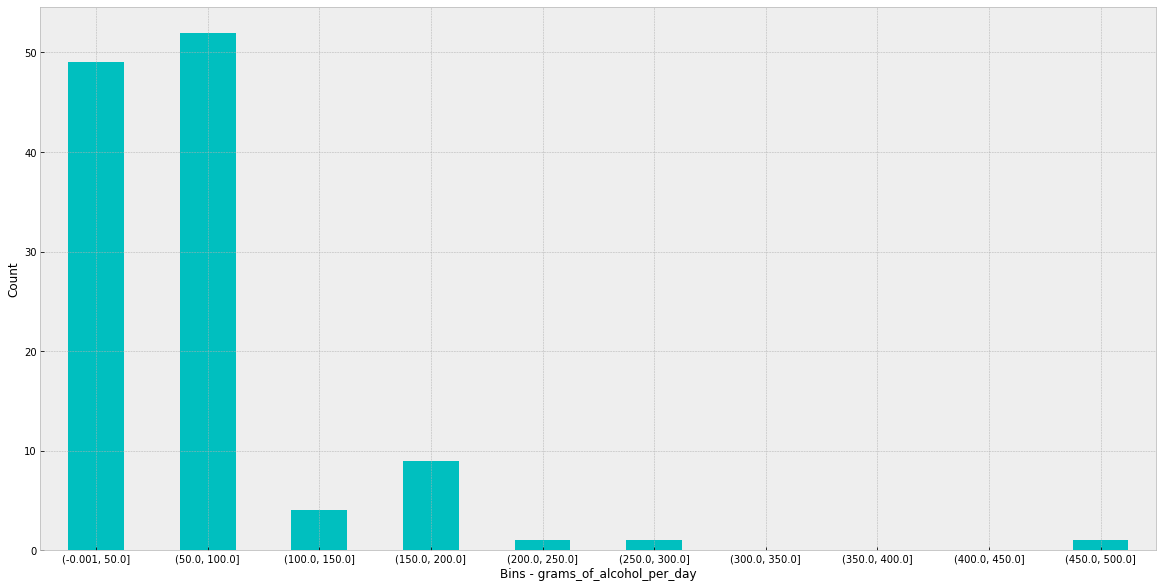

In [ ]:
bins = [
    0, 50, 100, 
    150, 200, 250, 
    300, 350, 400,
    450, 500
]

out = pd.cut(
    data.grams_of_alcohol_per_day, 
    bins=bins,
    include_lowest=True
)

ax = out.value_counts(sort=False).plot.bar(
    rot=0, 
    color='c', 
    figsize=(20,10)
)

plt.xlabel('Bins - grams_of_alcohol_per_day')
plt.ylabel('Count')
plt.show()

### PACKS_OF_CIGARETS_PER_YEAR VS CLASS_ATTRIBUTE (SURVIVAL)

In [ ]:
data['packs_of_cigarets_per_year'].isnull().sum()

53

In [ ]:
max(data['packs_of_cigarets_per_year'])

510.0

In [ ]:
min(data['packs_of_cigarets_per_year'])

0.0

In [ ]:
data['packs_of_cigarets_per_year'].mean()

20.464285714285715

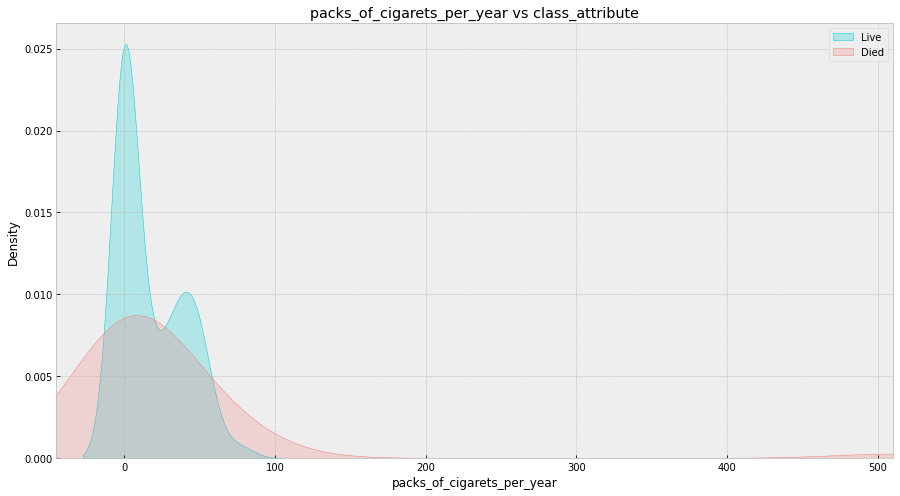

In [ ]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data["packs_of_cigarets_per_year"][data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data["packs_of_cigarets_per_year"][data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('packs_of_cigarets_per_year vs class_attribute')
plt.xlim(-45, 510)
plt.show()

#### What do we know about the survival ?

In [ ]:
data['class_attribute'].value_counts()

1    102
0     63
Name: class_attribute, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

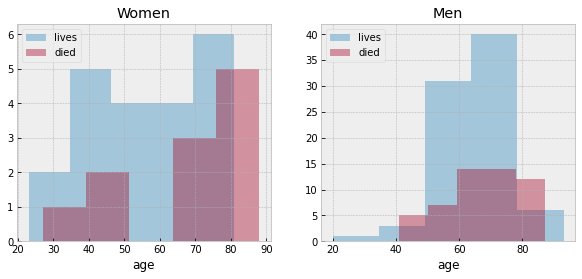

In [ ]:
lives = 'lives'
died = 'died'

fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(10, 4)
)

# 0-women, 1-men
women = data[data['gender'] == 0]
men = data[data['gender'] == 1]

ax = sns.distplot(
    women[women['class_attribute'] == 1].age.dropna(), 
    bins=5, 
    label=lives, 
    ax=axes[0], 
    kde=False
)

ax = sns.distplot(
    women[women['class_attribute'] == 0].age.dropna(),
    bins=5, 
    label=died, 
    ax=axes[0], 
    kde=False
)

ax.legend()
ax.set_title('Women')

ax = sns.distplot(
    men[men['class_attribute'] == 1].age.dropna(), 
    bins=5, 
    label=lives, 
    ax=axes[1], 
    kde=False
)

ax = sns.distplot(
    men[men['class_attribute'] == 0].age.dropna(), 
    bins=5, 
    label = died, 
    ax = axes[1], 
    kde = False
)

ax.legend()
_ = ax.set_title('Men')

We can see that men are more susceptible to die.

In [ ]:
data['class_attribute'].isnull().sum()

0

In [ ]:
data['gender'].isnull().sum()

0

In [ ]:
data.groupby(['gender','class_attribute'])['class_attribute'].count()

gender  class_attribute
0       0                  11
        1                  21
1       0                  52
        1                  81
Name: class_attribute, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


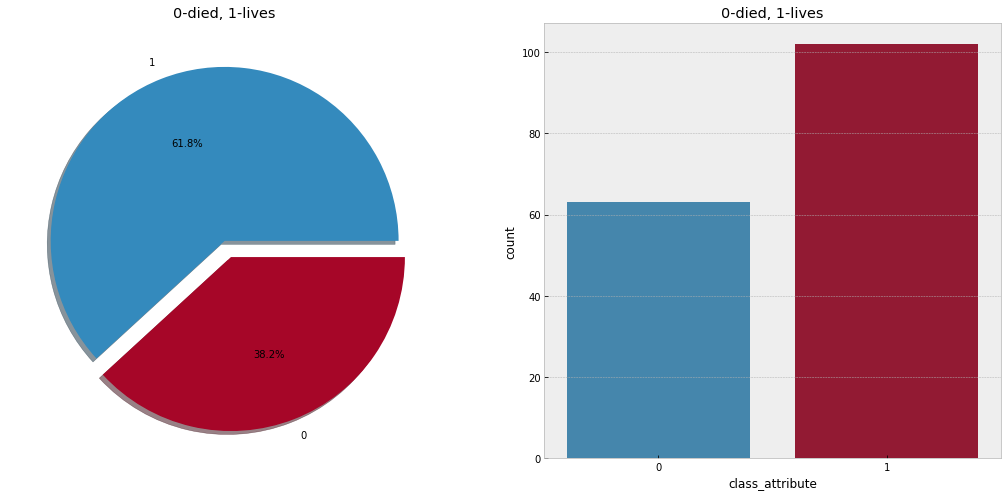

In [ ]:
f, ax=plt.subplots(
    1,
    2,
    figsize=(18,8)
)

data['class_attribute'].value_counts().plot.pie(
    explode=[0,0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)

ax[0].set_title('0-died, 1-lives')
ax[0].set_ylabel('')

sns.countplot(
    'class_attribute',
    data=data,ax=ax[1]
)

ax[1].set_title('0-died, 1-lives')

plt.show()

### MISSING VALUES

In [ ]:
total_missing_data = data.isnull().sum().sort_values(ascending=False)

percent_of_missing_data = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
    [
        total_missing_data, 
        percent_of_missing_data
    ], 
    axis=1, 
    keys=['Total', 'Percent']
)

missing_data.head(15)

,Total,Percent
oxygen_saturation_%,80,0.484848
ferritin,80,0.484848
iron,79,0.478788
packs_of_cigarets_per_year,53,0.321212
esophageal_varices,52,0.315152
grams_of_alcohol_per_day,48,0.290909
direct_bilirubin_mg/dL,44,0.266667
smoking,41,0.248485
hepatitis_b_e_antigen,39,0.236364
endemic_countries,39,0.236364


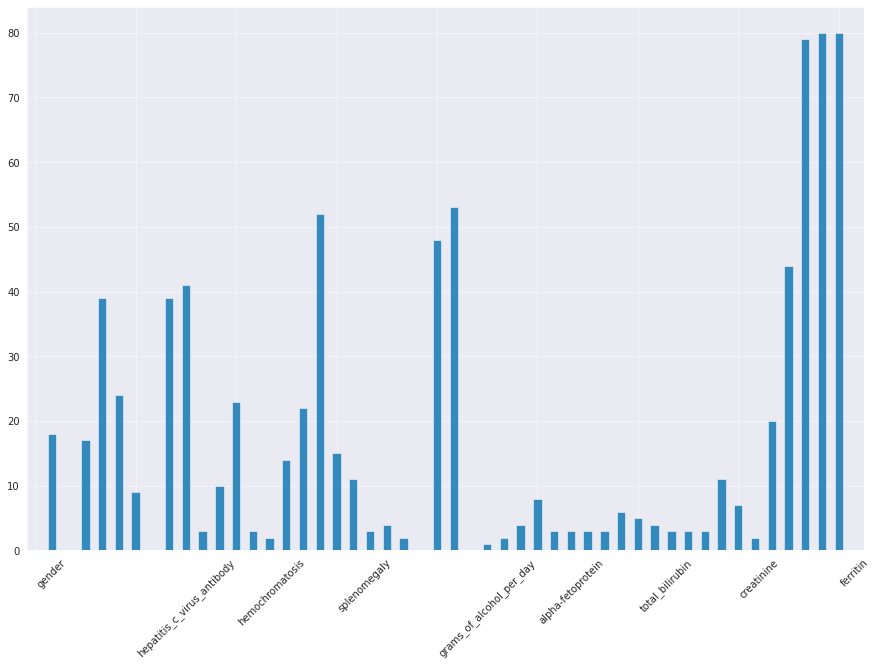

In [ ]:
cons = data.loc[:, :]

cons['null_values'] = cons.isnull().sum(axis=1)

null_values = cons.drop('null_values', axis=1).isnull().sum()

sns.set_style("darkgrid")

plt.figure(figsize=(15,10))

pbar = null_values.plot.bar()

plt.xticks(
    list(range(0,len(null_values.index),6)), 
    list(null_values.index[0::6]), 
    rotation=45, 
    ha='left'
)

plt.show()

In [ ]:
data.groupby('class_attribute').count()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,null_values
class_attribute,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,63,62,63,53,46,50,57,63,48,46,63,59,47,62,63,55,53,35,57,61,63,62,63,63,50,40,63,63,63,63,60,63,63,63,63,62,63,62,63,63,63,61,61,63,54,48,39,39,40,63
1,102,85,102,95,80,91,99,102,78,78,99,96,95,100,100,96,90,78,93,93,99,99,100,102,67,72,102,101,100,98,97,99,99,99,99,97,97,99,99,99,99,93,97,100,91,73,47,46,45,102


In [ ]:
data2 = data.drop(columns=['null_values'])

### HEATMAP WITH NaN

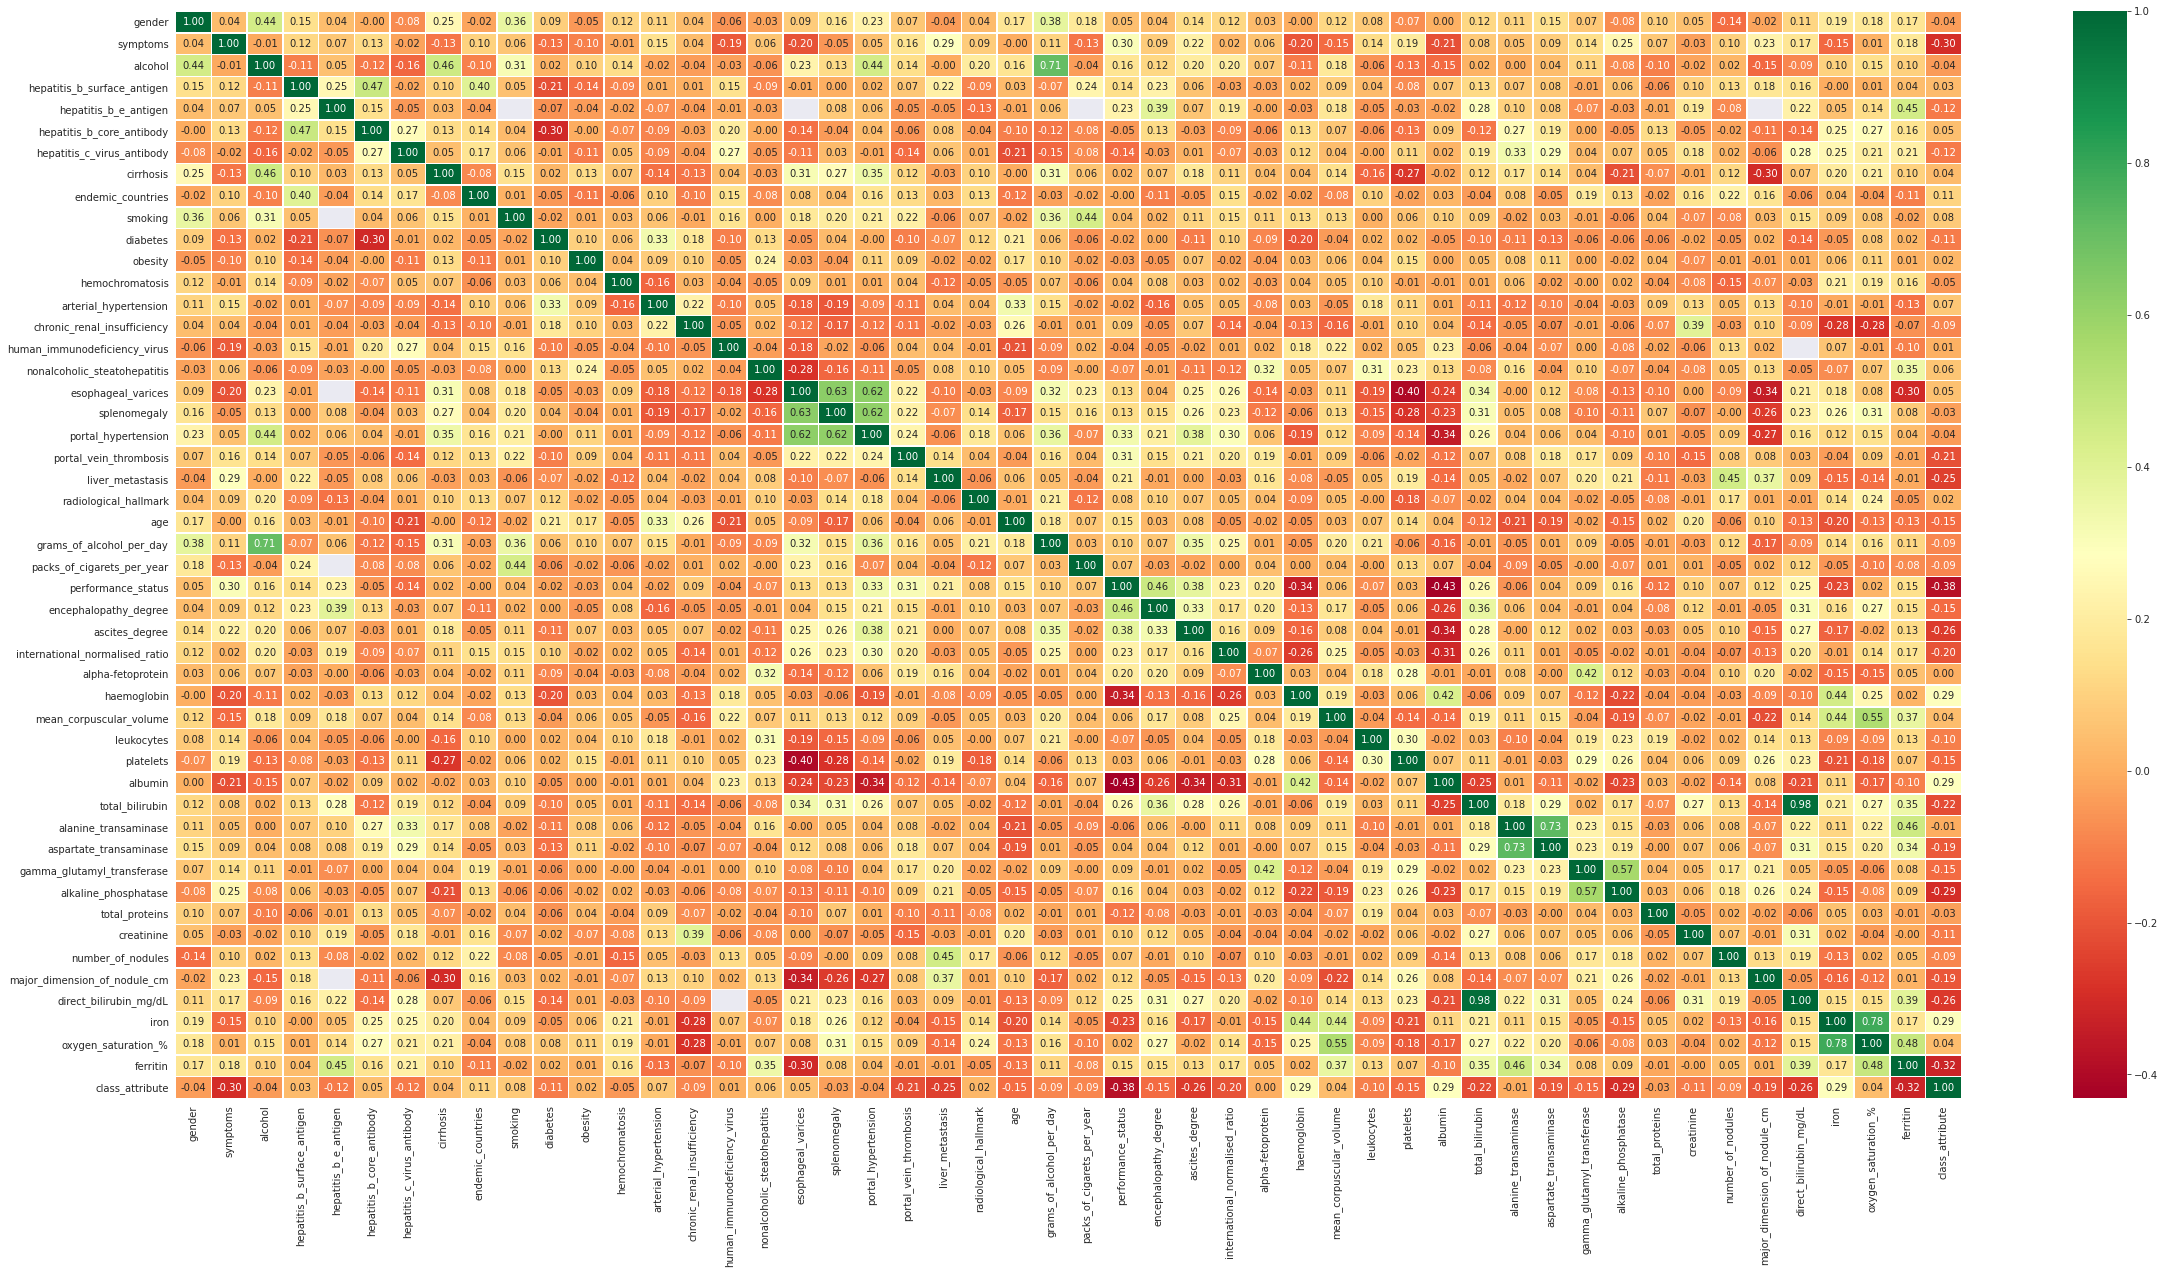

In [ ]:
corr = data2.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

### WORKING WITH MISSING VALUES

In [ ]:
def prepare_missing_values_for_nans(df=None, columns=None):
    """
    Looking for the most frequent value for both decision classes outputs - 0,1.
    """
    
    to_update_nans_dict = {}
    
    if columns:
        for decision_class in [0, 1]:
            for column in columns:
                vals = df[df.class_attribute == decision_class][column].value_counts()
                
                to_update_nans_dict['{decision_class}_{column}'.format(
                    decision_class=decision_class,
                    column=column
                )] = vals.idxmax()
                
        return to_update_nans_dict

In [ ]:
def replace_missing_values(df=None, columns=None, to_update_nans_dict=None):
    """
    Replacing NaN with the most frequent values for both decission classes outputs - 0,1.
    """
    
    df_list = []
    
    if columns:
        for decision_class in [0, 1]:
            _df = df[df.class_attribute == decision_class].reset_index(drop=True)

            for column in columns:        
                _df[column] = _df[column].fillna(
                    to_update_nans_dict['{}_{}'.format(decision_class, column)]
            )

            df_list.append(_df)

        return df_list

### NOMINAL VALUES

In [ ]:
# replacing NaNs with the most frequent value in column
nominal_indexes = [
    1, 3, 4, 5, 
    6, 8, 9, 10, 
    11, 12, 13, 
    14, 15, 16, 
    17, 18, 19, 
    20, 21, 22
]

nominal_columns_to_discretize = list(itemgetter(*nominal_indexes)(columns))

In [ ]:
# prepare missing values
nominal_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=nominal_columns_to_discretize
)

# replace NaN
missing_nominal_values_list = replace_missing_values(
    df=data2,
    columns=nominal_columns_to_discretize,
    to_update_nans_dict=nominal_dict

)

# data2[nominal_columns_to_discretize] = data2[nominal_columns_to_discretize].apply(
#     lambda x:x.fillna(x.value_counts().index[0])
# )

In [ ]:
data2 = pd.concat(missing_nominal_values_list).reset_index(drop=True)

### CONTINUOUS VALUES

In [ ]:
# KNN imputation
# Nearest neighbor imputations which weights samples 
# using the mean squared difference on features 
# for which two rows both have observed data.
continuous_indexes = [
    24,25,29,30,
    31,32,33,34,
    35,36,37,38,
    39,40,41,42,
    44,45,46,47,
    48]


continuous_columns_to_discretize = list(
    itemgetter(*continuous_indexes)(columns)
)

continuous_data = data2[continuous_columns_to_discretize].to_numpy()

In [ ]:
# method 1 - KNN neighbours
X_filled_knn = KNN(k=3).fit_transform(continuous_data)

data2[continuous_columns_to_discretize] = X_filled_knn

Imputing row 1/165 with 0 missing, elapsed time: 0.010
Imputing row 101/165 with 0 missing, elapsed time: 0.010


/usr/local/lib/python3.6/dist-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


In [ ]:
X_filled_knn.shape

(165, 21)

### INTEGER VALUES

In [ ]:
integer_columns = ['age', 'number_of_nodules']

# prepare missing integer values
integer_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=integer_columns
)

In [ ]:
integer_dict

{'0_age': 72,
 '0_number_of_nodules': 5.0,
 '1_age': 71,
 '1_number_of_nodules': 1.0}

In [ ]:
# replace NaN
missing_integer_values_list = replace_missing_values(
    df=data2,
    columns=integer_columns,
    to_update_nans_dict=integer_dict

)

In [ ]:
data2 = pd.concat(missing_integer_values_list).reset_index(drop=True)

### ORDINAL VALUES

In [ ]:
data2['ascites_degree'].value_counts()

1.0    109
2.0     36
3.0     18
Name: ascites_degree, dtype: int64

In [ ]:
ordinal_columns = ['encephalopathy_degree', 'ascites_degree', 'performance_status']

In [ ]:
# prepare missing ordinal values
ordinal_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=ordinal_columns
)

In [ ]:
ordinal_dict

{'0_ascites_degree': 1.0,
 '0_encephalopathy_degree': 1.0,
 '0_performance_status': 0,
 '1_ascites_degree': 1.0,
 '1_encephalopathy_degree': 1.0,
 '1_performance_status': 0}

In [ ]:
# replace NaN
missing_ordinal_values_list = replace_missing_values(
    df=data2,
    columns=ordinal_columns,
    to_update_nans_dict=ordinal_dict

)

In [ ]:
data2 = pd.concat(missing_ordinal_values_list).reset_index(drop=True)

In [ ]:
data2[data2.isnull().any(axis=1)]

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute


### ORDINAL COLUMNS BINARIZING

In [ ]:
ordinal_columns

['encephalopathy_degree', 'ascites_degree', 'performance_status']

In [ ]:
binarized_data = []

for c in ordinal_columns:
    lb = LabelBinarizer()
    
    lb.fit(data2[c].values)
    
    binarized = lb.transform(data2[c].values)
    binarized_data.append(binarized)

In [ ]:
binarized_ordinal_matrix_data = np.hstack(binarized_data)

In [ ]:
binarized_ordinal_matrix_data

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### BINARIZING number_of_nodules

In [ ]:
list(set(data2.number_of_nodules.values))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [ ]:
lb = LabelBinarizer()

lb.fit(data2.number_of_nodules.values)

binarized_number_of_nodules = lb.transform(data2.number_of_nodules.values)

### AGE AVERAGING

In [ ]:
data2['age_'] = data2.age.apply(lambda x: x / data2.age.max())

In [ ]:
data2['age_'].head(10)

0    0.827957
1    0.806452
2    0.526882
3    0.655914
4    0.440860
5    0.774194
6    0.806452
7    0.709677
8    0.688172
9    0.903226
Name: age_, dtype: float64

In [ ]:
age_ = data2.age_.values.reshape(-1,1)

### HEATMAP AFTER IMPUTATION

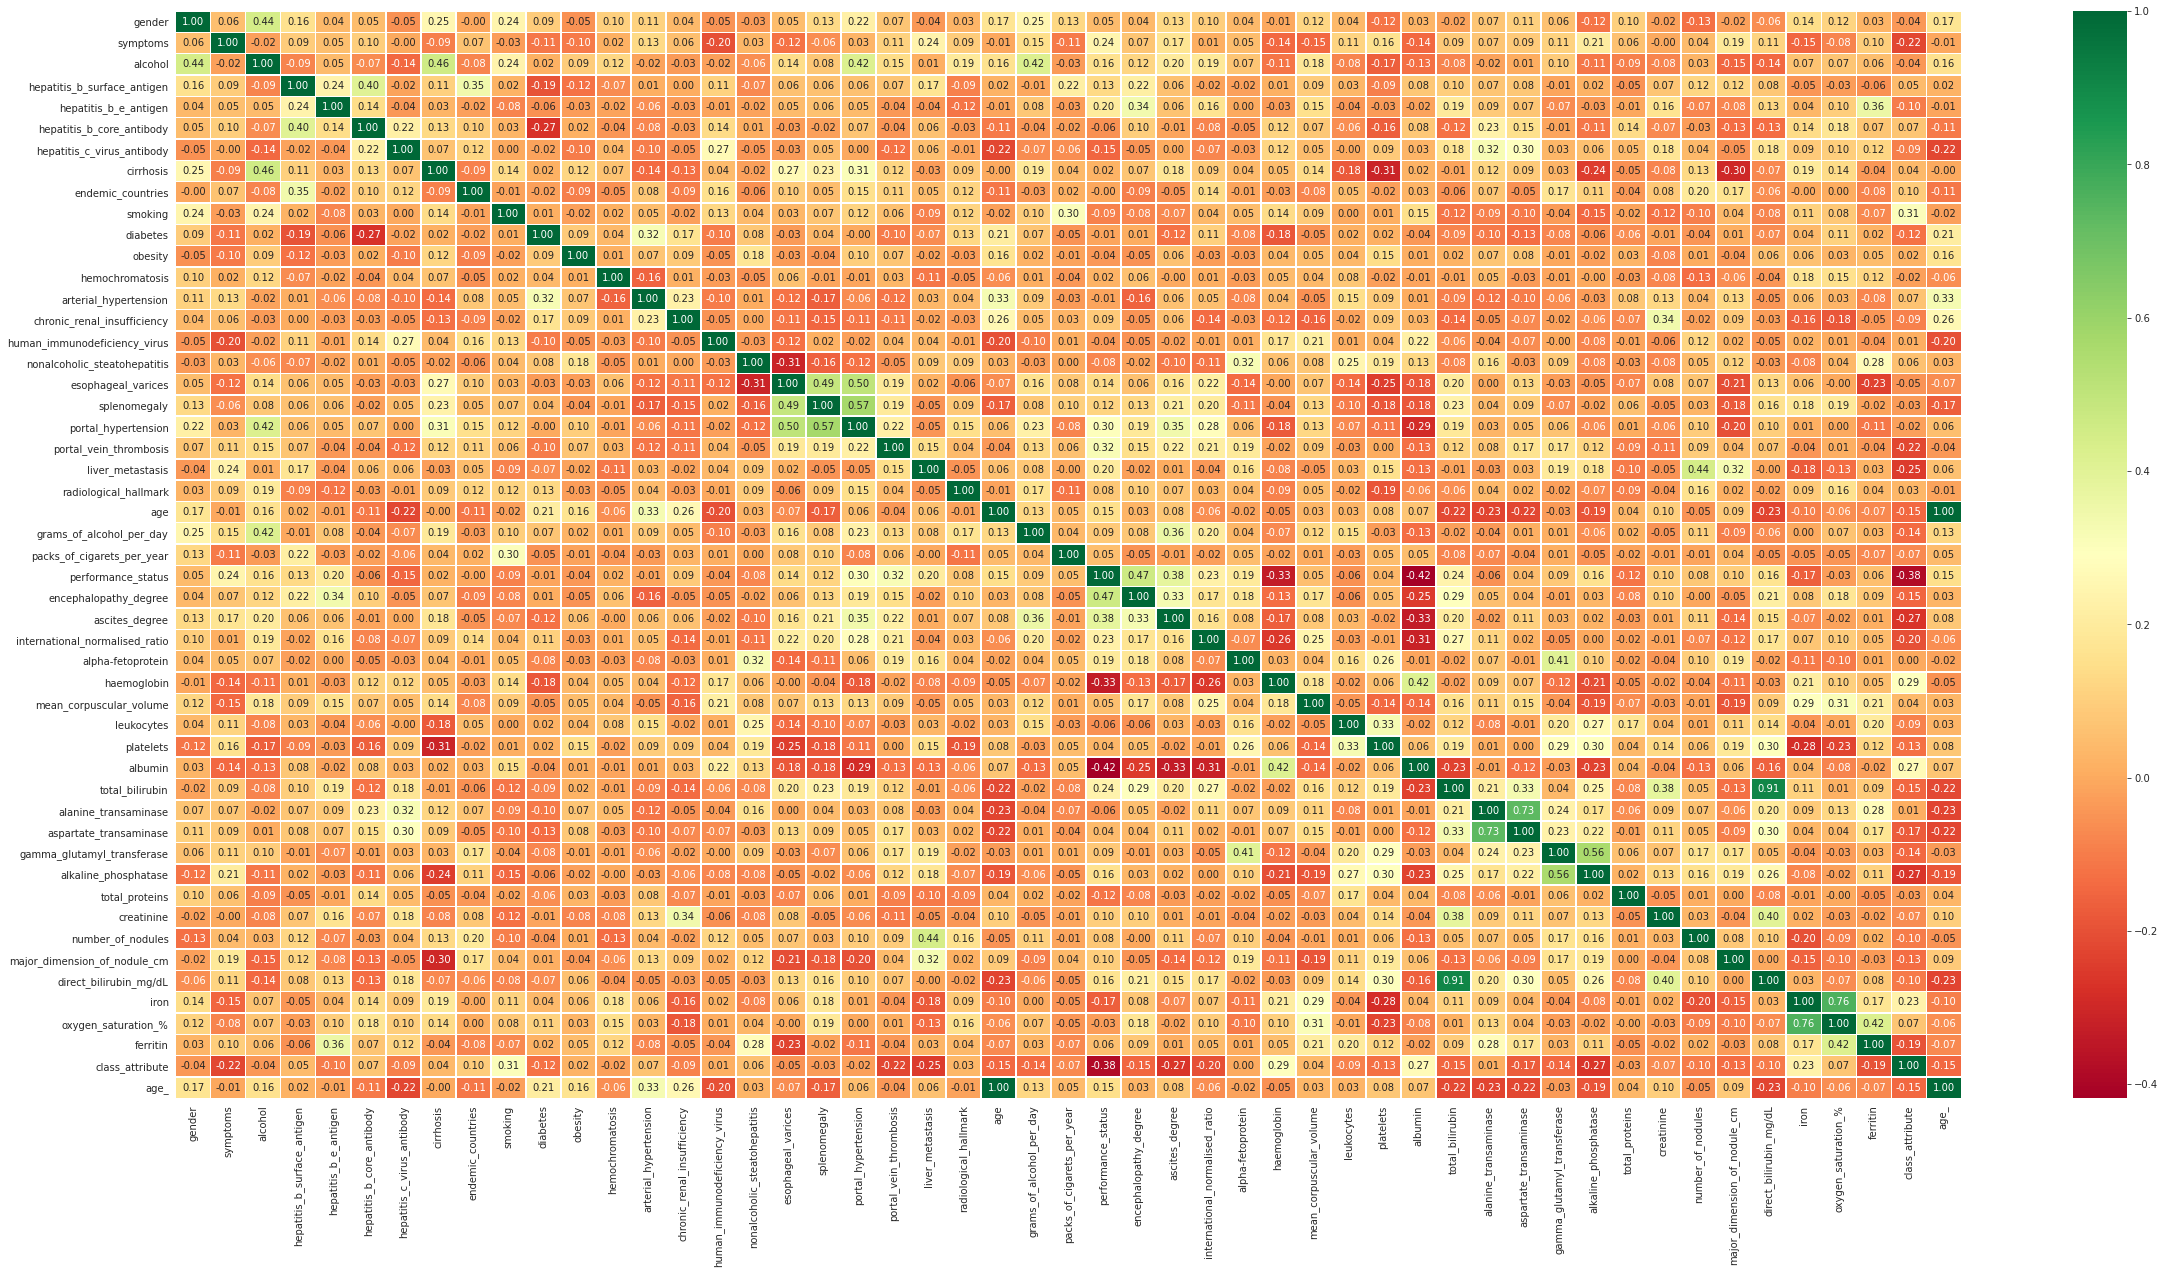

In [ ]:
corr = data2.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

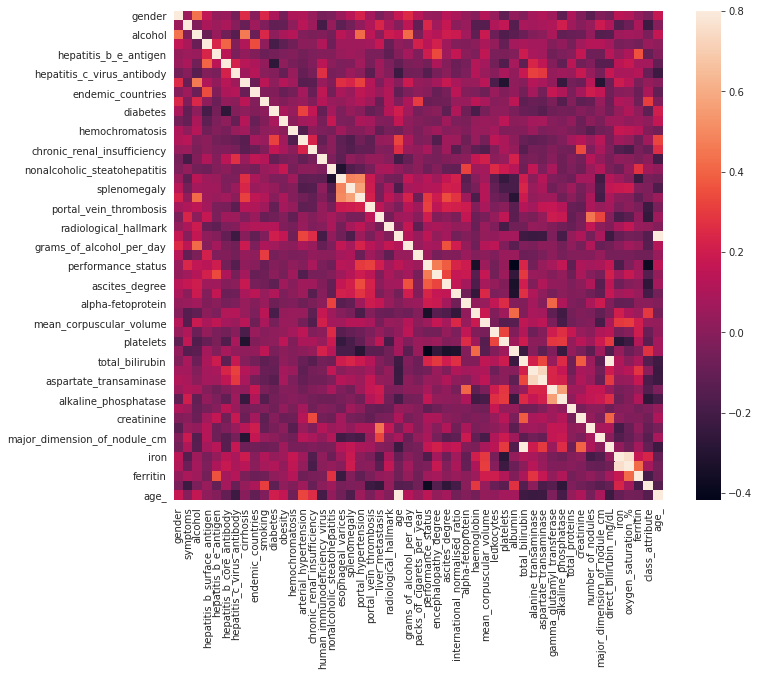

In [ ]:
f, ax = plt.subplots(
    figsize=(12, 9)
)

sns.heatmap(
    data2.corr(), 
    vmax=.8, 
    square=True
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17d4825cf8>,
      dtype=object)

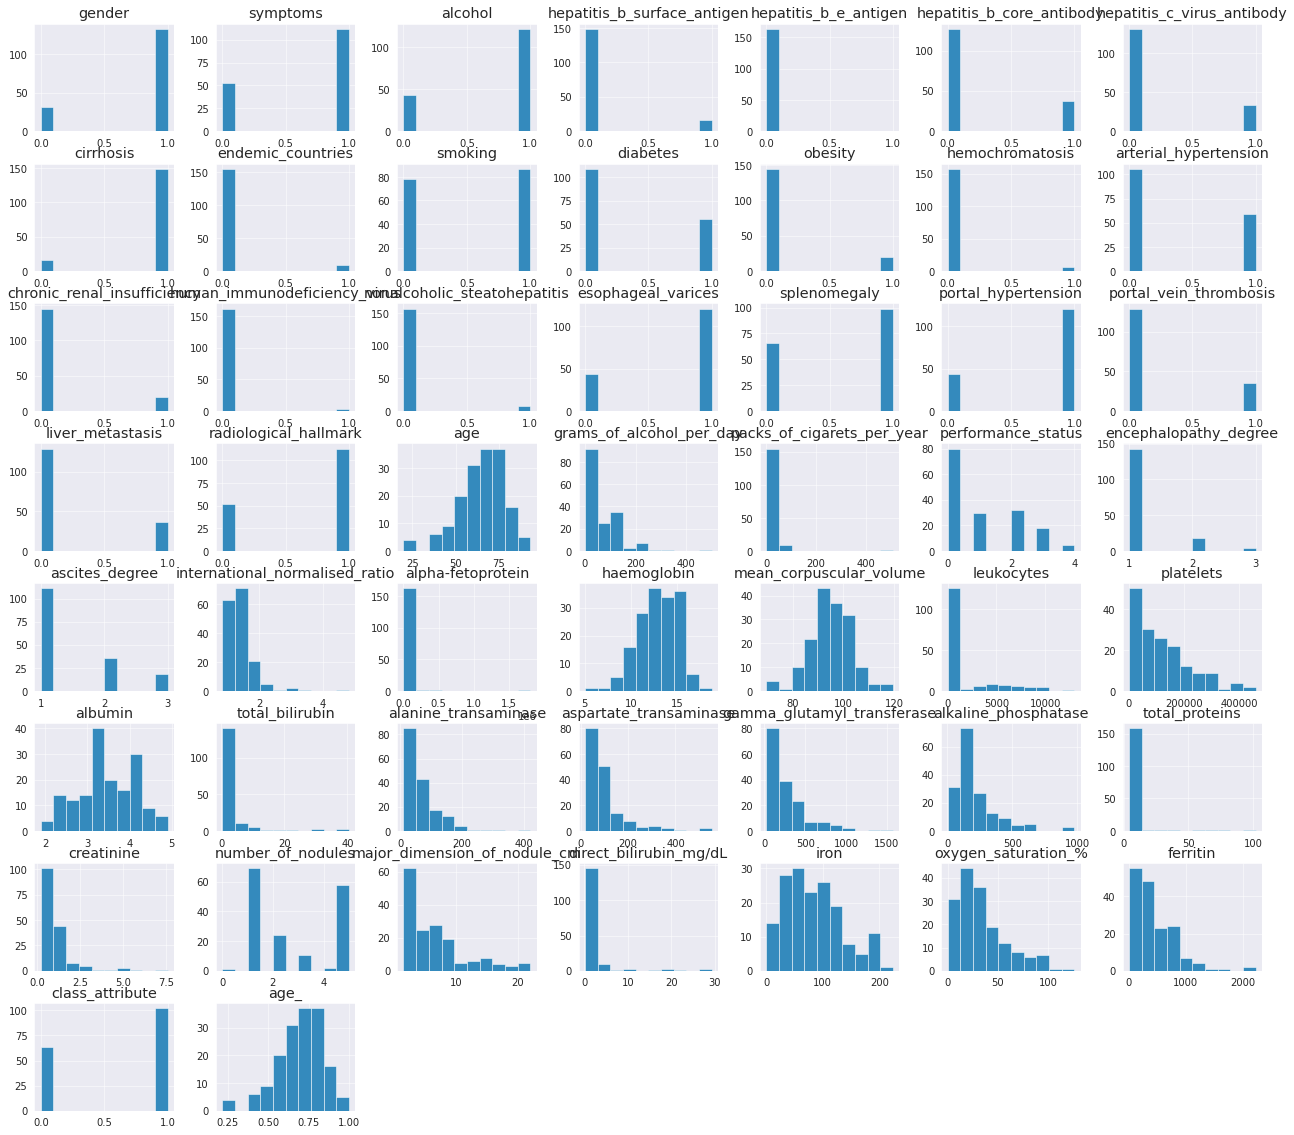

In [ ]:
data2.hist(figsize=(22,20))

### SPLITTING DATA

We have binarized ordinal values so we don't want to include its initial form to our X dataset.
Also the age column values have been averaged.

In [ ]:
to_drop_columns = [
    'age', 
    'encephalopathy_degree', 
    'ascites_degree', 
    'performance_status', 
    'number_of_nodules'
]

columns_set = set(columns)

_columns = list(columns_set.difference(to_drop_columns))

In [ ]:
len(columns)

50

In [ ]:
len(_columns)

45

In [ ]:
data2.head()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute,age_
0,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.000000,30.000000,0,1.0,1.0,0.95,2440.0,13.4,97.1,9.0,279.0,3.70,0.40,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.700000,0.20,71.658458,26.132335,399.772698,0,0.827957
1,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,75,1.449521,0.000000,1,1.0,2.0,1.58,110.0,13.4,91.5,5.4,85.0,3.40,3.50,91.0,122.0,242.0,396.0,5.6,0.90,1.0,10.000000,1.40,53.000000,22.000000,111.000000,0,0.806452
2,1,0.0,0,0.0,0.0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,49,0.000000,0.000000,0,1.0,1.0,1.40,138.9,10.4,102.0,3.2,42000.0,2.35,2.72,119.0,183.0,143.0,211.0,7.3,0.80,5.0,2.600000,2.19,171.000000,126.000000,1452.000000,0,0.526882
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,61,0.006973,20.000000,3,1.0,1.0,1.46,9860.0,10.8,92.0,3.0,58.0,3.10,3.20,79.0,108.0,184.0,300.0,7.1,0.52,2.0,9.000000,1.30,42.000000,25.000000,706.000000,0,0.655914
4,1,0.0,1,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,41,52.389143,46.519351,0,1.0,2.0,1.05,100809.0,13.0,94.2,5.7,196.0,4.40,3.00,90.0,334.0,494.0,236.0,7.6,0.80,5.0,2.825013,1.10,42.373775,17.538103,202.523324,0,0.440860


In [ ]:
X = data2[_columns].to_numpy()
y = data2.class_attribute.values

In [ ]:
data2[_columns]

,nonalcoholic_steatohepatitis,albumin,oxygen_saturation_%,chronic_renal_insufficiency,symptoms,esophageal_varices,human_immunodeficiency_virus,hepatitis_b_e_antigen,portal_hypertension,radiological_hallmark,grams_of_alcohol_per_day,haemoglobin,gamma_glutamyl_transferase,major_dimension_of_nodule_cm,creatinine,hepatitis_c_virus_antibody,alkaline_phosphatase,total_proteins,packs_of_cigarets_per_year,aspartate_transaminase,endemic_countries,cirrhosis,international_normalised_ratio,smoking,obesity,alpha-fetoprotein,ferritin,leukocytes,platelets,hemochromatosis,diabetes,hepatitis_b_core_antibody,hepatitis_b_surface_antigen,arterial_hypertension,mean_corpuscular_volume,class_attribute,iron,splenomegaly,gender,alcohol,direct_bilirubin_mg/dL,liver_metastasis,portal_vein_thrombosis,alanine_transaminase,total_bilirubin
0,0.0,3.70,26.132335,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40.000000,13.4,94.0,15.700000,1.11,0.0,174.0,8.1,3.000000e+01,64.0,0.0,1,0.95,1.0,0.0,2440.000000,399.772698,9.0,279.0,0.0,1.0,0.0,0.0,1.0,97.1,0,71.658458,0.0,1,1,0.200000,1.0,0.0,16.0,0.40
1,0.0,3.40,22.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.449521,13.4,242.0,10.000000,0.90,0.0,396.0,5.6,0.000000e+00,122.0,0.0,1,1.58,0.0,1.0,110.000000,111.000000,5.4,85.0,0.0,0.0,0.0,0.0,0.0,91.5,0,53.000000,1.0,1,1,1.400000,0.0,0.0,91.0,3.50
2,0.0,2.35,126.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,10.4,143.0,2.600000,0.80,1.0,211.0,7.3,0.000000e+00,183.0,0.0,1,1.40,0.0,0.0,138.900000,1452.000000,3.2,42000.0,0.0,1.0,1.0,0.0,0.0,102.0,0,171.000000,0.0,1,0,2.190000,0.0,0.0,119.0,2.72
3,0.0,3.10,25.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.006973,10.8,184.0,9.000000,0.52,0.0,300.0,7.1,2.000000e+01,108.0,0.0,1,1.46,1.0,0.0,9860.000000,706.000000,3.0,58.0,0.0,1.0,0.0,0.0,0.0,92.0,0,42.000000,1.0,1,1,1.300000,0.0,1.0,79.0,3.20
4,0.0,4.40,17.538103,0.0,0.0,1.0,0.0,0.0,1.0,1.0,52.389143,13.0,494.0,2.825013,0.80,1.0,236.0,7.6,4.651935e+01,334.0,0.0,1,1.05,0.0,0.0,100809.000000,202.523324,5.7,196.0,0.0,0.0,0.0,0.0,0.0,94.2,0,42.373775,1.0,1,1,1.100000,0.0,0.0,90.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.0,2.82,31.474347,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,11.7,120.0,1.900000,0.64,0.0,318.0,6.4,0.000000e+00,50.0,0.0,1,1.52,0.0,0.0,615.000000,255.424693,5.6,70000.0,0.0,1.0,0.0,0.0,0.0,99.7,1,71.460483,1.0,0,0,1.000000,0.0,0.0,66.0,3.00
161,0.0,3.50,49.246157,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.000000,14.7,67.0,3.500000,0.76,0.0,97.0,7.3,2.000000e+01,24.0,0.0,1,1.41,1.0,0.0,1.700000,213.347792,6900.0,72000.0,0.0,0.0,0.0,0.0,1.0,97.2,1,115.900579,1.0,1,1,0.300000,0.0,0.0,31.0,1.30
162,0.0,3.60,43.168314,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.000000,8.2,450.0,7.500000,1.49,0.0,263.0,6.8,6.481933e-11,59.0,0.0,1,1.16,1.0,0.0,1713.000000,349.369509,6.0,209000.0,0.0,1.0,0.0,0.0,0.0,94.2,1,122.988495,1.0,1,0,0.774433,0.0,0.0,62.0,0.30
163,0.0,4.60,48.704977,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,15.4,449.0,3.000000,0.70,1.0,109.0,7.6,0.000000e+00,40.0,0.0,1,0.84,1.0,0.0,1.500034,596.027501,9.3,184000.0,0.0,0.0,0.0,0.0,0.0,109.2,1,101.060763,0.0,0,1,0.332674,0.0,0.0,35.0,0.50


In [ ]:
data2[columns]

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,diabetes,obesity,hemochromatosis,arterial_hypertension,chronic_renal_insufficiency,human_immunodeficiency_virus,nonalcoholic_steatohepatitis,esophageal_varices,splenomegaly,portal_hypertension,portal_vein_thrombosis,liver_metastasis,radiological_hallmark,age,grams_of_alcohol_per_day,packs_of_cigarets_per_year,performance_status,encephalopathy_degree,ascites_degree,international_normalised_ratio,alpha-fetoprotein,haemoglobin,mean_corpuscular_volume,leukocytes,platelets,albumin,total_bilirubin,alanine_transaminase,aspartate_transaminase,gamma_glutamyl_transferase,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute
0,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.000000,3.000000e+01,0,1.0,1.0,0.95,2440.000000,13.4,97.1,9.0,279.0,3.70,0.40,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.700000,0.200000,71.658458,26.132335,399.772698,0
1,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,75,1.449521,0.000000e+00,1,1.0,2.0,1.58,110.000000,13.4,91.5,5.4,85.0,3.40,3.50,91.0,122.0,242.0,396.0,5.6,0.90,1.0,10.000000,1.400000,53.000000,22.000000,111.000000,0
2,1,0.0,0,0.0,0.0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,49,0.000000,0.000000e+00,0,1.0,1.0,1.40,138.900000,10.4,102.0,3.2,42000.0,2.35,2.72,119.0,183.0,143.0,211.0,7.3,0.80,5.0,2.600000,2.190000,171.000000,126.000000,1452.000000,0
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,61,0.006973,2.000000e+01,3,1.0,1.0,1.46,9860.000000,10.8,92.0,3.0,58.0,3.10,3.20,79.0,108.0,184.0,300.0,7.1,0.52,2.0,9.000000,1.300000,42.000000,25.000000,706.000000,0
4,1,0.0,1,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,41,52.389143,4.651935e+01,0,1.0,2.0,1.05,100809.000000,13.0,94.2,5.7,196.0,4.40,3.00,90.0,334.0,494.0,236.0,7.6,0.80,5.0,2.825013,1.100000,42.373775,17.538103,202.523324,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,36,0.000000,0.000000e+00,0,1.0,1.0,1.52,615.000000,11.7,99.7,5.6,70000.0,2.82,3.00,66.0,50.0,120.0,318.0,6.4,0.64,5.0,1.900000,1.000000,71.460483,31.474347,255.424693,1
161,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,62,0.000000,2.000000e+01,0,1.0,2.0,1.41,1.700000,14.7,97.2,6900.0,72000.0,3.50,1.30,31.0,24.0,67.0,97.0,7.3,0.76,1.0,3.500000,0.300000,115.900579,49.246157,213.347792,1
162,1,1.0,0,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,71,0.000000,6.481933e-11,3,1.0,1.0,1.16,1713.000000,8.2,94.2,6.0,209000.0,3.60,0.30,62.0,59.0,450.0,263.0,6.8,1.49,1.0,7.500000,0.774433,122.988495,43.168314,349.369509,1
163,0,0.0,1,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.000000,0.000000e+00,0,1.0,1.0,0.84,1.500034,15.4,109.2,9.3,184000.0,4.60,0.50,35.0,40.0,449.0,109.0,7.6,0.70,5.0,3.000000,0.332674,101.060763,48.704977,596.027501,1


In [ ]:
X_new = np.hstack((X, binarized_ordinal_matrix_data, age_, binarized_number_of_nodules))

In [ ]:
X_new.shape

(165, 63)

### STANDARIZATION - OPTIONAL

In [ ]:
std_scaler = StandardScaler() #StandardScaler() # RobustScaler
X_new = std_scaler.fit_transform(X_new)

### SPLITTING DATA INTO TRAIN AND TEST DATASETS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    random_state=42,
    test_size=0.20
)

In [ ]:
X_new

array([[-0.22573306,  0.3885741 , -0.32443598, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -0.05503426, -0.48838376, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.60766349,  3.6377511 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       ...,
       [-0.22573306,  0.24070464,  0.35145585, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306,  1.71939915,  0.57111948, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  1.2757908 , -0.91062204, ..., -0.26726124,
        -0.11076976,  1.3582443 ]])

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)


Training Features Shape: (132, 63)
Training Labels Shape: (132,)
Testing Features Shape: (33, 63)
Testing Labels Shape: (33,)


### LOGISTIC REGRESSION

In [ ]:
log_reg = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    C=0.1,
    multi_class='ovr',
    penalty='l2',
)

In [ ]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg_predict = log_reg.predict(X_test)

In [ ]:
log_reg.score(X_test, y_test)

0.9696969696969697

In [ ]:
preds = log_reg.predict(X_test)

In [ ]:
print('\nLogistic Regression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('Logistic Regression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict) * 100))
print('Logistic Regression Classification report:\n\n', classification_report(y_test, log_reg_predict))


Logistic Regression Accuracy: 96.97%
Logistic Regression AUC: 97.37%
Logistic Regression Classification report:

               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.95      0.97        19

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33



### RANDOM FORREST

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 0.0 degrees.


In [ ]:
X_test

array([[-0.22573306,  1.86726861, -0.56270003, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.9800519 ,  0.37464233, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.09012041, -0.59253462, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       ...,
       [-0.22573306,  1.86726861, -0.2900119 , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -0.49864261, -0.1313144 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.64651206, -0.33075634, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
X_train

array([[-0.22573306,  1.12792135,  1.32608   , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.60766349,  3.6377511 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -1.25277681, -0.47515897, ..., -0.26726124,
        -0.11076976, -0.73624458],
       ...,
       [-0.22573306,  0.24070464, -1.00415062, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.35077316, -0.51248434, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.09283519,  0.38312859, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
y_train

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [ ]:
y_test

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
# Saving feature names for later use
feature_list = list(data2.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: albumin              Importance: 1.0
Variable: gender               Importance: 0.0
Variable: symptoms             Importance: 0.0
Variable: alcohol              Importance: 0.0
Variable: hepatitis_b_surface_antigen Importance: 0.0
Variable: hepatitis_b_e_antigen Importance: 0.0
Variable: hepatitis_b_core_antibody Importance: 0.0
Variable: hepatitis_c_virus_antibody Importance: 0.0
Variable: cirrhosis            Importance: 0.0
Variable: endemic_countries    Importance: 0.0
Variable: smoking              Importance: 0.0
Variable: diabetes             Importance: 0.0
Variable: obesity              Importance: 0.0
Variable: hemochromatosis      Importance: 0.0
Variable: arterial_hypertension Importance: 0.0
Variable: chronic_renal_insufficiency Importance: 0.0
Variable: human_immunodeficiency_virus Importance: 0.0
Variable: nonalcoholic_steatohepatitis Importance: 0.0
Variable: esophageal_varices   Importance: 0.0
Variable: splenomegaly         Importance: 0.0
Variable: portal_

In [ ]:
predictions = rf.predict(X_test)
predictions

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.])

In [ ]:
rf.score(X_test, y_test)

1.0

In [ ]:
y_test

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
print('\nRandom Forest Accuracy: {:.2f}%'.format(accuracy_score(y_test, predictions) * 100))
print('Random Forest AUC: {:.2f}%'.format(roc_auc_score(y_test, predictions) * 100))
print('Random Forest Classification report:\n\n', classification_report(y_test, predictions))


Random Forest Accuracy: 100.00%
Random Forest AUC: 100.00%
Random Forest Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        19

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



### KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Use the KNN's predict method on the test data
knn_predict = knn.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [ ]:
X_test


array([[-0.22573306,  1.86726861, -0.56270003, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.9800519 ,  0.37464233, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.09012041, -0.59253462, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       ...,
       [-0.22573306,  1.86726861, -0.2900119 , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -0.49864261, -0.1313144 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.64651206, -0.33075634, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
X_train

array([[-0.22573306,  1.12792135,  1.32608   , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.60766349,  3.6377511 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -1.25277681, -0.47515897, ..., -0.26726124,
        -0.11076976, -0.73624458],
       ...,
       [-0.22573306,  0.24070464, -1.00415062, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.35077316, -0.51248434, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.09283519,  0.38312859, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
y_test

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
y_train

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [ ]:
knn_predict = knn.predict(X_test)

In [ ]:
knn.score(X_test, y_test)

0.696969696969697

In [ ]:
print('\nK-NN Accuracy: {:.2f}%'.format(accuracy_score(y_test, knn_predict) * 100))
print('\nK-NN AUC: {:.2f}%'.format(roc_auc_score(y_test, knn_predict) * 100))
print('\nK-NN Classification report:\n\n', classification_report(y_test, knn_predict))


K-NN Accuracy: 69.70%

K-NN AUC: 65.23%

K-NN Classification report:

               precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.67      0.95      0.78        19

    accuracy                           0.70        33
   macro avg       0.75      0.65      0.64        33
weighted avg       0.74      0.70      0.66        33



### NAIVE BAYES



In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nbtrain = nb.fit(X_train, y_train)

In [ ]:
# Use the BAYES's predict method on the test data
nb_predict = nb.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [ ]:
X_test

array([[-0.22573306,  1.86726861, -0.56270003, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.9800519 ,  0.37464233, ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.09012041, -0.59253462, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       ...,
       [-0.22573306,  1.86726861, -0.2900119 , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -0.49864261, -0.1313144 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.64651206, -0.33075634, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
X_train

array([[-0.22573306,  1.12792135,  1.32608   , ..., -0.26726124,
        -0.11076976, -0.73624458],
       [-0.22573306, -1.60766349,  3.6377511 , ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -1.25277681, -0.47515897, ..., -0.26726124,
        -0.11076976, -0.73624458],
       ...,
       [-0.22573306,  0.24070464, -1.00415062, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306, -0.35077316, -0.51248434, ..., -0.26726124,
        -0.11076976,  1.3582443 ],
       [-0.22573306,  0.09283519,  0.38312859, ..., -0.26726124,
        -0.11076976, -0.73624458]])

In [ ]:
y_test

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
y_train

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [ ]:
nb_predict = nb.predict(X_test)

In [ ]:
nb.score(X_test, y_test)

1.0

In [ ]:
print('\nNAIVE BAYES Accuracy: {:.2f}%'.format(accuracy_score(y_test, knn_predict) * 100))
print('\nNAIVE BAYES AUC: {:.2f}%'.format(roc_auc_score(y_test, knn_predict) * 100))
print('\nNAIVE BAYES Classification report:\n\n', classification_report(y_test, knn_predict))


NAIVE BAYES Accuracy: 69.70%

NAIVE BAYES AUC: 65.23%

NAIVE BAYES Classification report:

               precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.67      0.95      0.78        19

    accuracy                           0.70        33
   macro avg       0.75      0.65      0.64        33
weighted avg       0.74      0.70      0.66        33



### F1 SCORE AFTER 5-FOLD CROSS-VALIDATION LOGISTIC REGRESSION


In [ ]:
kfold = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

predicted = cross_val_predict(
    log_reg, 
    X_new, 
    y, 
    cv=kfold
)

scores = cross_val_score(
    log_reg, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("LogisticRegression: F1 after 5-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [0.97435897 1.         0.97560976 0.95238095 0.97674419]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        63
           1       0.97      0.98      0.98       102

    accuracy                           0.97       165
   macro avg       0.97      0.97      0.97       165
weighted avg       0.97      0.97      0.97       165

LogisticRegression: F1 after 5-fold cross-validation: 97.58% (+/- 0.03%)


### F1 SCORE AFTER 5-FOLD CROSS-VALIDATION RANDOM FOREST

```
# This is formatted as code
```



In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
kfold = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

predicted = cross_val_predict(
    rf, 
    X_new, 
    y, 
    cv=kfold
)

scores = cross_val_score(
    rf, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("Random Forest: F1 after 5-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [1. 1. 1. 1. 1.]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       102

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165

Random Forest: F1 after 5-fold cross-validation: 100.00% (+/- 0.00%)


### F1 SCORE AFTER 5-FOLD CROSS-VALIDATION NAIVE BAYES

```
# This is formatted as code
```



In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(
    knn, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("KNN: F1 after 5-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [0.9        0.85106383 0.8        0.82608696 0.8372093 ]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       102

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165

KNN: F1 after 5-fold cross-validation: 84.29% (+/- 0.07%)


### F1 SCORE AFTER 5-FOLD CROSS-VALIDATION NAIVE BAYES

```
# This is formatted as code
```



In [ ]:
nb = GaussianNB()

scores = cross_val_score(
    nb, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("Naive Bayes: F1 after 5-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [1.         1.         1.         1.         0.97674419]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       102

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165

Naive Bayes: F1 after 5-fold cross-validation: 99.53% (+/- 0.02%)
